# NTUT DRL Homework 2: CarRacing

CarRacing is the continuous control task learning from pixels, a top-down racing environment. State consists of 96x96 pixels. Reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles in track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points. CarRacing-v0 defines "solving" as getting average reward of 900 over 100 consecutive trials.
This example notebook refers to the github:

https://github.com/Rafael1s/Deep-Reinforcement-Learning-Udacity/tree/master/CarRacing-From-Pixels-PPO

### Install video rendering dependancies, which takes around 45 seconds

In [1]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get update  > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg  > /dev/null 2>&1

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

### Video Display Functions

In [4]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [5]:
# Install CarRacing environment (in Box2D)
!pip install Box2D

     |████████████████████████████████| 1.3 MB 5.9 MB/s eta 0:00:01


In [6]:
env = wrap_env(gym.make("CarRacing-v0"))

In [7]:
# Test Environment and Show Videos
observation = env.reset()
while True:
    env.render()
    action = env.action_space.sample() 
    observation, reward, done, info = env.step(action)         
    if done: 
      break;
env.close()
show_video()

Track generation: 1175..1473 -> 298-tiles track


In [8]:
# Import Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import time
from collections import deque

In [9]:
class Net(nn.Module):
    """
    Convolutional Neural Network for PPO
    """

    def __init__(self, img_stack):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(img_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v

In [10]:
img_stack=4

transition = np.dtype([('s', np.float64, (img_stack, 96, 96)), 
                       ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (img_stack, 96, 96))])

GAMMA=0.99
EPOCH= 8 # beter than 10
MAX_SIZE = 2000 ## CUDA out of mem for max_size=10000
BATCH=128 
EPS=0.1
LEARNING_RATE = 0.001 # bettr than 0.005 or 0.002 

class Agent():
    """ Agent for training """
    
    def __init__(self, device):
        self.training_step = 0
        self.net = Net(img_stack).double().to(device)
        self.buffer = np.empty(MAX_SIZE, dtype=transition)
        self.counter = 0
        self.device = device
        
        self.optimizer = optim.Adam(self.net.parameters(), lr=LEARNING_RATE)  ## lr=1e-3

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(self.device).unsqueeze(0)
        
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp


    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == MAX_SIZE:
            self.counter = 0
            return True
        else:
            return False

    def update(self):
        self.training_step += 1

        s = torch.tensor(self.buffer['s'], dtype=torch.double).to(self.device)
        a = torch.tensor(self.buffer['a'], dtype=torch.double).to(self.device)
        r = torch.tensor(self.buffer['r'], dtype=torch.double).to(self.device).view(-1, 1)
        next_s = torch.tensor(self.buffer['s_'], dtype=torch.double).to(self.device)

        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype=torch.double).to(self.device).view(-1, 1)

        with torch.no_grad():
            target_v = r + GAMMA * self.net(next_s)[1]
            adv = target_v - self.net(s)[1]
            # adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        for _ in range(EPOCH):
            for index in BatchSampler(SubsetRandomSampler(range(MAX_SIZE)), BATCH, False):

                alpha, beta = self.net(s[index])[0]
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])

                surr1 = ratio * adv[index]
                
                # clipped function
                surr2 = torch.clamp(ratio, 1.0 - EPS, 1.0 + EPS) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])
                loss = action_loss + 2. * value_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

### Initializing Training Environment

In [11]:
# Initializing Training Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

seed = 0 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

action_repeat = 10
env = gym.make('CarRacing-v0', verbose=0)
state = env.reset()
print('env.action_space.shape: ', env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print('reward_threshold', reward_threshold)

device:  cpu
env.action_space.shape:  (3,)
reward_threshold 900


### Preprocessing CarRacing Screenshots

frame.shape:  (96, 96, 3)
img.shape:  (96, 96)


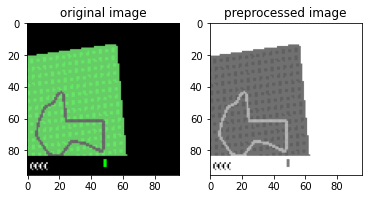

In [12]:
# show what a preprocessed image looks like
frame, _, _, _ = env.step(np.array([2., 1., 1.]))

print('frame.shape: ', frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

#-------------------------------#

def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
    gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    if norm:
        # normalize
        gray = gray / 128. - 1.
    return gray

img_gray = rgb2gray(frame)

#-------------------------------# 
plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

### Define Wrapper for Our Environment

In [13]:
class Wrapper():
    """
    Environment wrapper for CarRacing 
    """

    def __init__(self, env):
        self.env = env  

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = env.reset()
        img_gray = rgb2gray(img_rgb)
        self.stack = [img_gray] * img_stack  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(action_repeat):
            img_rgb, reward, die, _ = env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == img_stack
        return np.array(self.stack), total_reward, done, die


    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [14]:
def save(agent, directory, filename, suffix):
    torch.save(agent.net.state_dict(), '%s/%s_%s.pth' % (directory, filename, suffix))

In [15]:
def ppo_train(n_episodes=500, save_every=100):
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    timestep_after_last_save = 0
    
    time_start = time.time()

    running_score = 0
    state = env_wrap.reset()
    
    i_lim = 0
    
    for i_episode in range(n_episodes):
        
        timestep = 0
        total_reward = 0
        
        ## score = 0
        state = env_wrap.reset()

        while True:    
            
            action, a_logp = agent.select_action(state)
            next_state, reward, done, die = env_wrap.step( 
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()
            
            total_reward += reward
            state = next_state
            
            timestep += 1  
            timestep_after_last_save += 1
            
            if done or die:
                break
                
        running_score = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        s = (int)(time.time() - time_start)        
        print('Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score {:.2f}, \
Time: {:02}:{:02}:{:02} '\
            .format(i_episode, timestep, \
                    total_reward, avg_score, running_score, s//3600, s%3600//60, s%60))  
       
        
        # Save episode is equal to "save_every" timesteps
        if i_episode+1 % save_every == 0:

            suf = str(i_episode)
            save(agent, '', 'model_weights', suf)
            
        if np.mean(scores_deque) > reward_threshold:
            print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !" \
                  .format(running_score, avg_score))
            break
            
    return scores_array, avg_scores_array    
            


### Training Agent

In [16]:
agent = Agent(device)

env_wrap = Wrapper(env)

NUM_EPISODES = 300

scores, avg_scores  = ppo_train(NUM_EPISODES)
# Save latest model. We'll use it for testing
save(agent, '.', 'model_weights', 'latest')

Ep. 0, Ep.Timesteps 84, Score: -21.39, Avg.Score: -21.39, Run.Score -0.21, Time: 00:00:19 
Ep. 1, Ep.Timesteps 88, Score: -18.02, Avg.Score: -19.71, Run.Score -0.39, Time: 00:00:38 
Ep. 2, Ep.Timesteps 93, Score: -23.95, Avg.Score: -21.12, Run.Score -0.63, Time: 00:00:59 
Ep. 3, Ep.Timesteps 93, Score: -23.90, Avg.Score: -21.81, Run.Score -0.86, Time: 00:01:20 
Ep. 4, Ep.Timesteps 100, Score: 87.84, Avg.Score: 0.12, Run.Score 0.03, Time: 00:01:42 
Ep. 5, Ep.Timesteps 100, Score: 99.32, Avg.Score: 16.65, Run.Score 1.02, Time: 00:02:04 
Ep. 6, Ep.Timesteps 80, Score: -17.91, Avg.Score: 11.71, Run.Score 0.83, Time: 00:02:22 
Ep. 7, Ep.Timesteps 88, Score: -26.42, Avg.Score: 6.94, Run.Score 0.56, Time: 00:02:42 
Ep. 8, Ep.Timesteps 91, Score: -23.52, Avg.Score: 3.56, Run.Score 0.32, Time: 00:03:03 
Ep. 9, Ep.Timesteps 88, Score: -24.21, Avg.Score: 0.78, Run.Score 0.07, Time: 00:03:23 
Ep. 10, Ep.Timesteps 84, Score: -23.18, Avg.Score: -1.40, Run.Score -0.16, Time: 00:03:43 
Ep. 11, Ep.Time

Ep. 91, Ep.Timesteps 84, Score: -4.96, Avg.Score: 8.49, Run.Score 4.38, Time: 00:39:41 
Ep. 92, Ep.Timesteps 94, Score: -17.84, Avg.Score: 8.20, Run.Score 4.16, Time: 00:40:02 
Ep. 93, Ep.Timesteps 63, Score: 11.43, Avg.Score: 8.24, Run.Score 4.24, Time: 00:40:15 
Ep. 94, Ep.Timesteps 83, Score: -17.81, Avg.Score: 7.96, Run.Score 4.01, Time: 00:40:36 
Ep. 95, Ep.Timesteps 81, Score: -17.84, Avg.Score: 7.69, Run.Score 3.80, Time: 00:40:55 
Ep. 96, Ep.Timesteps 100, Score: 82.76, Avg.Score: 8.47, Run.Score 4.59, Time: 00:41:17 
Ep. 97, Ep.Timesteps 83, Score: -5.87, Avg.Score: 8.32, Run.Score 4.48, Time: 00:41:36 
Ep. 98, Ep.Timesteps 93, Score: -17.87, Avg.Score: 8.06, Run.Score 4.26, Time: 00:41:56 
Ep. 99, Ep.Timesteps 86, Score: -18.06, Avg.Score: 7.80, Run.Score 4.03, Time: 00:42:16 
Ep. 100, Ep.Timesteps 100, Score: 90.91, Avg.Score: 8.92, Run.Score 4.90, Time: 00:42:38 
Ep. 101, Ep.Timesteps 83, Score: -9.17, Avg.Score: 9.01, Run.Score 4.76, Time: 00:42:56 
Ep. 102, Ep.Timesteps 8

Ep. 183, Ep.Timesteps 47, Score: -14.79, Avg.Score: 5.76, Run.Score 5.42, Time: 01:13:15 
Ep. 184, Ep.Timesteps 93, Score: -17.91, Avg.Score: 5.58, Run.Score 5.19, Time: 01:13:36 
Ep. 185, Ep.Timesteps 64, Score: -3.34, Avg.Score: 5.72, Run.Score 5.10, Time: 01:13:51 
Ep. 186, Ep.Timesteps 53, Score: 1.39, Avg.Score: 5.92, Run.Score 5.06, Time: 01:14:03 
Ep. 187, Ep.Timesteps 82, Score: -18.04, Avg.Score: 4.84, Run.Score 4.83, Time: 01:14:21 
Ep. 188, Ep.Timesteps 99, Score: -17.95, Avg.Score: 4.84, Run.Score 4.60, Time: 01:14:46 
Ep. 189, Ep.Timesteps 100, Score: 127.09, Avg.Score: 6.35, Run.Score 5.83, Time: 01:15:08 
updating
Ep. 190, Ep.Timesteps 87, Score: -18.01, Avg.Score: 6.32, Run.Score 5.59, Time: 01:17:48 
Ep. 191, Ep.Timesteps 100, Score: 136.03, Avg.Score: 7.73, Run.Score 6.90, Time: 01:18:11 
Ep. 192, Ep.Timesteps 60, Score: 16.71, Avg.Score: 8.08, Run.Score 6.99, Time: 01:18:24 
Ep. 193, Ep.Timesteps 62, Score: 12.47, Avg.Score: 8.09, Run.Score 7.05, Time: 01:18:38 
Ep. 

Ep. 274, Ep.Timesteps 35, Score: 8.89, Avg.Score: 13.02, Run.Score 10.11, Time: 01:42:42 
Ep. 275, Ep.Timesteps 78, Score: 15.27, Avg.Score: 13.02, Run.Score 10.16, Time: 01:42:59 
Ep. 276, Ep.Timesteps 37, Score: 15.10, Avg.Score: 13.09, Run.Score 10.21, Time: 01:43:07 
Ep. 277, Ep.Timesteps 41, Score: 14.04, Avg.Score: 13.05, Run.Score 10.25, Time: 01:43:17 
Ep. 278, Ep.Timesteps 70, Score: -18.05, Avg.Score: 13.05, Run.Score 9.96, Time: 01:43:34 
Ep. 279, Ep.Timesteps 41, Score: 14.15, Avg.Score: 13.00, Run.Score 10.00, Time: 01:43:43 
Ep. 280, Ep.Timesteps 47, Score: 14.39, Avg.Score: 13.32, Run.Score 10.05, Time: 01:43:53 
Ep. 281, Ep.Timesteps 59, Score: 12.17, Avg.Score: 13.63, Run.Score 10.07, Time: 01:44:06 
Ep. 282, Ep.Timesteps 56, Score: 18.42, Avg.Score: 13.73, Run.Score 10.15, Time: 01:44:18 
updating
Ep. 283, Ep.Timesteps 63, Score: 21.52, Avg.Score: 14.09, Run.Score 10.27, Time: 01:46:37 
Ep. 284, Ep.Timesteps 76, Score: -18.02, Avg.Score: 14.09, Run.Score 9.98, Time: 0

length of scores:  300 , len of avg_scores:  300


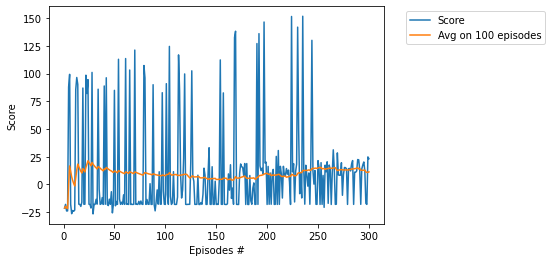

In [17]:
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [18]:
def load(agent, directory, filename):
    agent.net.load_state_dict(torch.load(os.path.join(directory,filename)))

In [19]:
def play(env, agent, n_episodes):
    state = env_wrap.reset()
    
    scores_deque = deque(maxlen=n_episodes)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        state = env_wrap.reset()        
        score = 0
        
        time_start = time.time()
        
        while True:
            action, a_logp = agent.select_action(state)
            env.render()
            next_state, reward, done, die = env_wrap.step( \
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            state = next_state
            score += reward
            
            if done or die:
                break 

        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)

        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))
    return np.mean(scores_deque)

In [20]:
# We use the average score of 10 episodes as result, Don't change n_episodes!!!
total_avg_reward = play(env, agent, n_episodes=10)

Episode 1	Average Score: 11.49,	Score: 11.49 	Time: 00:00:06
Episode 2	Average Score: 10.84,	Score: 10.20 	Time: 00:00:15
Episode 3	Average Score: 1.20,	Score: -18.09 	Time: 00:00:11
Episode 4	Average Score: 3.95,	Score: 12.19 	Time: 00:00:06
Episode 5	Average Score: 7.65,	Score: 22.44 	Time: 00:00:11
Episode 6	Average Score: 9.35,	Score: 17.85 	Time: 00:00:11
Episode 7	Average Score: 9.61,	Score: 11.17 	Time: 00:00:10
Episode 8	Average Score: 12.53,	Score: 33.02 	Time: 00:00:12
Episode 9	Average Score: 13.01,	Score: 16.82 	Time: 00:00:16
Episode 10	Average Score: 12.64,	Score: 9.32 	Time: 00:00:08


In [21]:
# Print results in CSV format and upload to Kaggle
with open('rewards.csv', 'w') as f:
    f.write('Id,Predicted\n')
    f.write('CarRacing_public,{}\n'.format(total_avg_reward))
    f.write('CarRacing_private,{}\n'.format(total_avg_reward))

# Download your results!
from IPython.display import FileLink
FileLink('rewards.csv')

/kaggle/working/rewards.csv

## Show Your Training Result

In [22]:
import os
env_test = Monitor(gym.make("CarRacing-v0"), './video', force=True)
env_test.reset()
env_wrap = Wrapper(env_test)
load(agent, '', 'model_weights_latest.pth')
play(env_test, agent, n_episodes=1)
while True:
    env_test.render()
    action = env_test.action_space.sample() 
    observation, reward, done, info = env_test.step(action)         
    if done: 
      break;
env_test.close()
show_video()

Track generation: 1112..1403 -> 291-tiles track
Episode 1	Average Score: 21.23,	Score: 21.23 	Time: 00:00:13
